# ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

El objetivo de nuestro proyecto es analizar el comportamiento de los clientes de Megaline y con ello verificar las siguientes hipotesis:

1. El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
2. El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.

Junto a estas hipótesis, nuestro objetivo final es descubrir que plan de telefonia es el que más ingresos genera y poder destinarle mayor inversión en su difusión

Para lograr este objetivo, realizaremos los siguientes pasos:

- Cargar la información y verificarla
- Hacer una análisis del comportamiento con los datos limpios y poder generar datos para probar las hipotesis presentadas
- Unir todos nuestros resultados y dar una respuesta a la pregunta presentada al inicio

## Inicialización

Para iniciar nuestro proyecto vamos a cargar nuestras librerias

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

## Cargar los datos

Vamos a cargar los datos repartidos en 5 datasets.
- megaline_calls.csv (datos de las llamadas)
- megaline_internet.csv (datos del internet)
- megaline_messages.csv (datos de los mensajes)
- megaline_plans.csv (datos sobre las tarifas)
- megaline_users.csv (datos sobre los usuarios)

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv('data/megaline_calls.csv')
internet = pd.read_csv('data/megaline_internet.csv')
messages = pd.read_csv('data/megaline_messages.csv')
plans = pd.read_csv('data/megaline_plans.csv')
users = pd.read_csv('data/megaline_users.csv')

## Preparar los datos

Ya que tenemos diferentes fuentes de datos, vamos a necesitar ir una por una viendo su composición, si hay algún error corregirlo y enriquecer el dataset de ser posible.

## Planes

In [3]:
# Imprime la información general/resumen sobre el DataFrame de los planes
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para los planes
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


En este dataset podemos ver la información de los 2 planes telefónicos que ofrece la compañia, entre ellos:
1. Los mensajes incluidos en el plan por mes `messages_included`
2. Los MB incluidos en el plan por mes `mb_per_month_included`
3. Los minutos incluidos al mes `minutes_included`
4. El costo del plan al mes en USD `usd_monthly_pay`
5. El costo por cada GB extra al incluido en USD `usd_per_gb`
6. El costo por cada mensaje extra al incluido en USD `usd_per_message`
7. El costo por cada minuto extra al incluido en USD `usd_per_minute`
8. El nombre de cada plan `plan_name`

Todos los tipos de datos estan correctos y no presentamos datos ausentes; por lo que no hay que hacer algún ajuste.

## Usuarios

In [5]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Imprime una muestra de los datos para los usuarios
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


En este dataset podemos ver la información de los 500 usuarios de la compañia, entre ellos:
1. ID del usuario `user_id`
2. Nombre del usuario `first_name`
3. Apellido del usuario `last_name`
4. Edad del usuario `age`
5. Ciudad de residencia del usuario `city`
6. Fecha de contratación del plan `reg_date`
7. Nombre del plan al que esta suscrito `plan`
8. Fecha en que el usuario dejó de usar el servicio `churn_date`

En el dataset vemos unas cuantas situaciones que necesitan nuestra atención:

- Datos no adecuados:
    1. El parámetro de `user_id` deberia ser pasado a object, ya que es una variable categorica más que una varibale númerica
    2. El parámetro de `reg_date` esta como object y deberia pasar a ser de tipo datetime
    3. El parámetro de `churn_date` esta como object y deberia pasar a ser de tipo datetime
    
    
- Datos ausentes:
    1. El parámetro de `churn_date` presenta solo 34 de 500 datos, debemos explorar porque es esto y rellenar nuestros datos

### Corregir datos

Empecemos haciendo el cambio de tipos en los datos

In [7]:
# User_id
users['user_id'] = users['user_id'].astype('object')

# reg_date
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

# reg_date
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [8]:
# Vemos la información general del dataset para ver los cambios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


In [9]:
# Vemos una muestra de la data con los nuevos tipos
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


Una vez corregidos los tipos, pasemos a ver el tema de los datos ausentes.

La métrica `churn_date` es la fecha en el que los usuarios dejaron de ocupar el servicio, por lo que si tiene data vacia es que el usuario sigue siendo activo dentro de la compañia. Sabiendo esto, podemos dejar nuestra columna como esta para no poder la info de esta fechas.

### Enriquecer datos

Una vez corregidos y verificados los errores en el dataset, podemos enriquecer nuestro dataset con las siguientes columnas:

1. `user_active` - Columna con valores de True si es usuario activo del servicio o False si ya no es parte del servicio

2. `days_suscribed` - Los días que el usuario estuvo suscrito al servicio, en caso de que siga siendo usuario activo se coloca un -1

3. `grouped_age` - Columna que agrupa las edades en diferentes categorias:
    - "Menor a 21" si el usuario es menor de edad
    - "21-30"
    - "31-40"
    - "41-50"
    - "51-60"
    - "60+" si el usuario es mayor a 60 años

In [10]:
# user_active
get_user_active = lambda x: True if x is pd.NaT else False
users['user_active'] = users.churn_date.dt.date.apply(get_user_active)
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,user_active
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,True
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,True
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,True
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,True
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,True


In [11]:
# days_suscribed
def get_days_suscribed(row):
    churn_date = row['churn_date']
    reg_date = row['reg_date']
    user_active = row['user_active']
    
    if user_active == True:
        return -1
    days = (churn_date - reg_date) / np.timedelta64(1, 'D')
    return days
        
users['days_suscribed'] = users.apply(get_days_suscribed, axis=1)
print(users.days_suscribed.value_counts())
print()
print(users.head())

-1.0      466
 160.0      2
 59.0       2
 21.0       2
 298.0      1
 164.0      1
 49.0       1
 182.0      1
 203.0      1
 234.0      1
 223.0      1
 179.0      1
 89.0       1
 291.0      1
 114.0      1
 93.0       1
 198.0      1
 174.0      1
 313.0      1
 9.0        1
 244.0      1
 47.0       1
 188.0      1
 43.0       1
 53.0       1
 61.0       1
 254.0      1
 201.0      1
 7.0        1
 140.0      1
 141.0      1
 144.0      1
Name: days_suscribed, dtype: int64

  user_id first_name  last_name  age                                   city  \
0    1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1    1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2    1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3    1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4    1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

    reg_date      plan churn_date  user_a

In [12]:
# grouped_age
def get_grouped_age(row):
    age = row['age']
    
    if age < 21:
        return "Menor a 21"
    elif age <= 30:
        return "21-30"
    elif age <= 40:
        return "31-40"
    elif age <= 50:
        return "41-50"
    elif age <= 60:
        return "51-60"
    else:
        return "60+"
    
        
users['grouped_age'] = users.apply(get_grouped_age, axis=1)
users.grouped_age.value_counts()

60+           126
21-30          96
41-50          82
51-60          82
31-40          78
Menor a 21     36
Name: grouped_age, dtype: int64

Con estas adiciones, tendremos más información para tener en cuenta para nuestros análisis

## Llamadas

In [13]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [14]:
# Imprime una muestra de datos para llamadas
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


En este dataset podemos ver la información de los 137,735 llamadas hechas por 500 usuarios de la compañia, entre los datos podemos encontrar:
1. ID de la llamada `id`
2. ID del usuario que hizo la llamada `user_id`
3. Fecha en la que se realizo la llamada `call_date`
4. Duración de la llamada `duration`

En el dataset vemos unas cuantas situaciones que necesitan nuestra atención:

- Datos no adecuados:
    1. El parámetro de `user_id` deberia ser pasado a object, ya que es una variable categorica más que una varibale númerica
    2. El parámetro de `call_date` esta como object y deberia pasar a ser de tipo datetime
    
    
- Llamadas con duración 0
    1. En el dataset tenemos llamadas que registran una duración de 0 segundos. Esta situación podria generarnos ruido en el analisis por lo que necesitamos explorar esta situación y decidir como tratarla

No contamos con datos ausentes en el dataset, por lo que no es requerido ningun tipo de adecuación en este aspecto

### Corregir datos

Ajustemos los tipos incorrectos que indentificamos en el dataset

In [15]:
# User_id
calls['user_id'] = calls['user_id'].astype('object')

# call_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# Verificamos que los tipos se hayan cambiado correctamente
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  object        
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.2+ MB


In [16]:
# Llamadas con duración 0
print('Llamadas con duración 0:', calls.query('duration < 1')['id'].count())
porcentaje = (calls.query('duration < 1')['id'].count() / calls.shape[0])
print(f'% respecto a la columna: {porcentaje:.2%}')

Llamadas con duración 0: 32559
% respecto a la columna: 23.64%


Tenemos que 23% de las llamadas tienen duración 0, es un porcentaje muy alto para eliminarlo, sin embargo podemos generar una columna extra llamada `call_lost` para identificar estas llamadas como llamadas perdidas y al resto como no perdidas.

In [17]:
# Generamos la columna extra con una función
get_call_lost = lambda x: True if x < 1 else False 
calls['call_lost'] = calls.duration.apply(get_call_lost)

# Verificamos que se haya creado correctamente
calls.call_lost.value_counts()

False    105176
True      32559
Name: call_lost, dtype: int64

Una vez generada la columna `call_lost`, podemos notar que 32,559 llamadas del total del dataset son llamadas perdidas

### Enriquecer datos

Una vez corregidos y verificados los errores en el dataset, podemos enriquecer nuestro dataset con las siguientes columnas:

1. `call_day` - Columna con el dia de la semana en que fue hecha la llamada
2. `call_month` - Columna con el mes que fue hecha la llamada

In [18]:
# Conseguimos el dia de la semana que se realizo la llamada
calls['call_day'] = pd.DatetimeIndex(calls['call_date']).day_name()

# Conseguimos el mes que se realizo la llamada
calls['call_month'] = pd.DatetimeIndex(calls['call_date']).month_name()

# Verificamos que se haya colocado correctamente
calls.head()

,id,user_id,call_date,duration,call_lost,call_day,call_month
0,1000_93,1000,2018-12-27,8.52,False,Thursday,December
1,1000_145,1000,2018-12-27,13.66,False,Thursday,December
2,1000_247,1000,2018-12-27,14.48,False,Thursday,December
3,1000_309,1000,2018-12-28,5.76,False,Friday,December
4,1000_380,1000,2018-12-30,4.22,False,Sunday,December


Con estas columnas extra, podriamos ver en que dia y mes los usuarios hacen más llamadas y diseñar promociones para esas temporalidades en especifico

## Mensajes

In [19]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [20]:
# Imprime una muestra de datos para los mensajes
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


En este dataset podemos ver la información de los 76,051 mensajes hechas por 500 usuarios de la compañia, entre los datos podemos encontrar:
1. ID del mensaje `id`
2. ID del usuario que mando el mensaje `user_id`
3. Fecha en la que se mando el mensaje `message_date`

En el dataset vemos unas cuantas situaciones que necesitan nuestra atención:

- Datos no adecuados:
    1. El parámetro de `user_id` deberia ser pasado a object, ya que es una variable categorica más que una varibale númerica
    2. El parámetro de `message_date` esta como object y deberia pasar a ser de tipo datetime

No contamos con datos ausentes en el dataset, por lo que no es requerido ningun tipo de adecuación en este aspecto

### Corregir datos

Procederemos a hacer las correcciones de tipos para las columnas identificadas

In [21]:
# User_id
messages['user_id'] = messages['user_id'].astype('object')

# call_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# Verificamos que los tipos se hayan cambiado correctamente
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Enriquecer datos

Una vez corregidos y verificados los errores en el dataset, podemos enriquecer nuestro dataset con las siguientes columnas:

1. `message_day` - Columna con el dia de la semana en que fue mandado el mensaje
2. `message_month` - Columna con el mes en que fue mandado el mensaje

In [22]:
# Conseguimos el dia de la semana que se mando el mensaje
messages['message_day'] = pd.DatetimeIndex(messages['message_date']).day_name()

# Conseguimos el mes que se mando el mensaje
messages['message_month'] = pd.DatetimeIndex(messages['message_date']).month_name()

# Verificamos que se haya colocado correctamente
messages.head()

,id,user_id,message_date,message_day,message_month
0,1000_125,1000,2018-12-27,Thursday,December
1,1000_160,1000,2018-12-31,Monday,December
2,1000_223,1000,2018-12-31,Monday,December
3,1000_251,1000,2018-12-27,Thursday,December
4,1000_255,1000,2018-12-26,Wednesday,December


Con estas columnas extra, podriamos ver en que dia y mes los usuarios mandan más mensajes y diseñar promociones para esas temporalidades en especifico

## Internet

In [23]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [24]:
# Imprime una muestra de datos para el tráfico de internet
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


En este dataset podemos ver la información de los 104,825 sesiones hechas por 500 usuarios de la compañia, entre los datos podemos encontrar:
1. ID de la sesión `id`
2. ID del usuario que tuvo la sesión `user_id`
3. Fecha en la que se realizo la sesión `session_date`
4. MB usados en la sesión `mb_used`

En el dataset vemos unas cuantas situaciones que necesitan nuestra atención:

- Datos no adecuados:
    1. El parámetro de `user_id` deberia ser pasado a object, ya que es una variable categorica más que una varibale númerica
    2. El parámetro de `session_date` esta como object y deberia pasar a ser de tipo datetime
    
    
- Sesiones con duración 0
    1. En el dataset tenemos sesiones que registran un consumo de 0 MB. Esta situación podria generarnos ruido en el analisis por lo que necesitamos explorarla y decidir como tratarla

No contamos con datos ausentes en el dataset, por lo que no es requerido ningun tipo de adecuación en este aspecto

### Corregir datos

Vamos a empezar corrigiendo los tipos de datos para las columnas identificadas

In [25]:
# user_id
internet['user_id'] = internet['user_id'].astype('object')

# session_date
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# Verificamos que los tipos se hayan cambiado correctamente
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ MB


In [26]:
# Sesiones con gasto de 0 MB
print('Sesiones con gasto de 0 MB:', internet.query('mb_used == 0')['id'].count())
porcentaje = (internet.query('mb_used == 0')['id'].count() / internet.shape[0])
print(f'% respecto a la columna: {porcentaje:.2%}')

Sesiones con gasto de 0 MB: 13747
% respecto a la columna: 13.11%


Debido a que son sesiones que al tener 0 gasto de MB no nos genera ningun tipo de información extra y representan el 13% de los datos totales de nuestra columna, se tomo la decisión de borrarlas del dataset

In [27]:
internet = internet[internet['mb_used'] > 0]
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91078 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            91078 non-null  object        
 1   user_id       91078 non-null  object        
 2   session_date  91078 non-null  datetime64[ns]
 3   mb_used       91078 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.5+ MB


### Enriquecer datos

Una vez corregidos y verificados los errores en el dataset, podemos enriquecer nuestro dataset con las siguientes columnas:

1. `session_day` - Columna con el dia de la semana en el que se tuvo la sesión
2. `session_month` - Columna con el mes en el que se tuvo la sesión

In [28]:
# Conseguimos el dia de la semana que se realizo la sesión
internet['session_day'] = pd.DatetimeIndex(internet['session_date']).day_name()

# Conseguimos el mes que se realizo la sesión
internet['session_month'] = pd.DatetimeIndex(internet['session_date']).month_name()

# Verificamos que se haya colocado correctamente
internet.head()

,id,user_id,session_date,mb_used,session_day,session_month
0,1000_13,1000,2018-12-29,89.86,Saturday,December
2,1000_379,1000,2018-12-28,660.40,Friday,December
3,1000_413,1000,2018-12-26,270.99,Wednesday,December
4,1000_442,1000,2018-12-27,880.22,Thursday,December
5,1001_0,1001,2018-08-24,284.68,Friday,August


Con estas columnas extra, podriamos ver en que dia y en que mes los usuarios gastan más MB y diseñar promociones para esas temporalidades en especifico

## Estudiar las condiciones del plan

Una vez revisado todos los datasets, estamos listos para seguir con nuestro análisis. Antes de continuar, vamos a revisar una vez más el dataset de planes, con el objetivo de entender como es su funcionamiento y cobros

In [29]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

Una vez que hayamos revisado el dataset de planes y entendido su funcionamiento, procederemos a agrupar datos por usuario.

Como pudimos notar en los datasets de llamadas, mensajes e internet. Tenemos muchos datos para user_ids repetidos, por lo que necesitamos agruparlas y con ello generar metricas más claras para cada usuario.

In [30]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.
calls_group = calls.groupby(['user_id', 'call_month']).agg(total_calls=('call_lost', 'count'), 
                                          calls_lost=('call_lost', 'sum')).reset_index()
calls_group['calls_success'] = calls_group.total_calls - calls_group.calls_lost
calls_group = calls_group.rename({"call_month": "month"}, axis=1)
calls_group

,user_id,month,total_calls,calls_lost,calls_success
0,1000,December,16,0,16
1,1001,August,27,6,21
2,1001,December,56,11,45
3,1001,November,64,20,44
4,1001,October,65,20,45
...,...,...,...,...,...
2253,1498,September,45,7,38
2254,1499,December,65,13,52
2255,1499,November,45,9,36
2256,1499,October,53,15,38


In [31]:
# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
minutes_group = calls.groupby(['user_id', 'call_month']).agg(total_minutes=('duration',
                                                                            'sum')).reset_index()
minutes_group = minutes_group.rename({"call_month": "month"}, axis=1)
minutes_group

,user_id,month,total_minutes
0,1000,December,116.83
1,1001,August,171.14
2,1001,December,392.93
3,1001,November,404.59
4,1001,October,374.11
...,...,...,...
2253,1498,September,344.62
2254,1499,December,468.10
2255,1499,November,288.56
2256,1499,October,363.28


In [32]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
messages_group = messages.groupby(['user_id', 'message_month']).agg(total_messages=('id',
                                                                            'count')).reset_index()
messages_group = messages_group.rename({"message_month": "month"}, axis=1)
messages_group

,user_id,month,total_messages
0,1000,December,11
1,1001,August,30
2,1001,December,44
3,1001,November,36
4,1001,October,53
...,...,...,...
1801,1496,December,11
1802,1496,November,13
1803,1496,October,18
1804,1496,September,21


In [33]:
# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
internet_group = internet.groupby(['user_id', 'session_month']).agg(total_mb_used=('mb_used',
                                                                            'sum')).reset_index()
internet_group = internet_group.rename({"session_month": "month"}, axis=1)
internet_group

,user_id,month,total_mb_used
0,1000,December,1901.47
1,1001,August,6919.15
2,1001,December,19369.18
3,1001,November,18504.30
4,1001,October,22330.49
...,...,...,...
2272,1498,September,22827.28
2273,1499,December,22059.21
2274,1499,November,16813.83
2275,1499,October,19492.43


Una vez generando las agrupaciones, lo siguiente que haremos sera unir todas estas agrupaciones en un solo dataset consolidado

In [34]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
data_consolidada = pd.merge(calls_group, minutes_group, how='inner', on=['user_id', 'month'])
data_consolidada = pd.merge(data_consolidada,
                            messages_group, how='outer',
                            on=['user_id', 'month'])
data_consolidada = pd.merge(data_consolidada,
                            internet_group, how='outer',
                            on=['user_id', 'month'])

# Nos aseguramos que no hayan quedado datos vacios
data_consolidada.fillna(0, inplace=True)
print(data_consolidada.info())
print()
print(data_consolidada.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2293 non-null   int64  
 1   month           2293 non-null   object 
 2   total_calls     2293 non-null   float64
 3   calls_lost      2293 non-null   float64
 4   calls_success   2293 non-null   float64
 5   total_minutes   2293 non-null   float64
 6   total_messages  2293 non-null   float64
 7   total_mb_used   2293 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 161.2+ KB
None

   user_id     month  total_calls  calls_lost  calls_success  total_minutes  \
0     1000  December         16.0         0.0           16.0         116.83   
1     1001    August         27.0         6.0           21.0         171.14   
2     1001  December         56.0        11.0           45.0         392.93   
3     1001  November         64.0        20.0           44

In [35]:
# Añade la información del plan
data_consolidada = data_consolidada.merge(users[['user_id', 'plan']],
                                          on='user_id', how='inner')
data_consolidada = data_consolidada.rename({"plan": "plan_name"}, axis=1)
data_consolidada = data_consolidada.merge(plans, on='plan_name', how='outer')
data_consolidada.head()

,user_id,month,total_calls,calls_lost,calls_success,total_minutes,total_messages,total_mb_used,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,December,16.0,0.0,16.0,116.83,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01
1,1006,December,9.0,2.0,7.0,54.79,139.0,32118.82,ultimate,1000,30720,3000,70,7,0.01,0.01
2,1006,November,2.0,0.0,2.0,9.32,15.0,2068.37,ultimate,1000,30720,3000,70,7,0.01,0.01
3,1008,December,85.0,22.0,63.0,600.29,26.0,14689.33,ultimate,1000,30720,3000,70,7,0.01,0.01
4,1008,November,63.0,15.0,48.0,422.81,37.0,23676.72,ultimate,1000,30720,3000,70,7,0.01,0.01


Una vez generado nuestro dataset consolidado con los totales por mes y el plan que cada usuario tenia, vamos a generar el ingreso mensual para cada usuario.

Para realizar esta tarea, vamos a seguir los siguientes pasos:
1. Restar el limite del paquete al número total tanto de minutos, SMS y datos.
2. Multiplicar ese resultado por el valor de cada tarifa
3. Agregar el cargo mensual + la tarifa extra que cada usuario genero

In [36]:
## Calcula el ingreso mensual para cada usuario

# Restar el limite del paquete al número total tanto de minutos, SMS y datos.
def extra_metrics(data, new_column_name, total, limit):
    data[new_column_name] = data[total] - data[limit]
    
extra_metrics(data_consolidada, 'extra_minutes', 'total_minutes', 'minutes_included')
extra_metrics(data_consolidada, 'extra_messages', 'total_messages', 'messages_included')
extra_metrics(data_consolidada, 'extra_mb', 'total_mb_used', 'mb_per_month_included')

# Verificar si el extra generado es positivo, si no pasarlo a 0 para poder hacer el calculo
verificar_extras = lambda x: 0 if x < 0 else x

# Aplicamos la funcion verificar_extras
data_consolidada['extra_minutes'] = data_consolidada['extra_minutes'].apply(verificar_extras)
data_consolidada['extra_messages'] = data_consolidada['extra_messages'].apply(verificar_extras)
data_consolidada['extra_mb'] = data_consolidada['extra_mb'].apply(verificar_extras)

# Revisamos que se hayan generado con exito las columnas
data_consolidada.head()

,user_id,month,total_calls,calls_lost,calls_success,total_minutes,total_messages,total_mb_used,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,extra_minutes,extra_messages,extra_mb
0,1000,December,16.0,0.0,16.0,116.83,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,0.00
1,1006,December,9.0,2.0,7.0,54.79,139.0,32118.82,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,1398.82
2,1006,November,2.0,0.0,2.0,9.32,15.0,2068.37,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,0.00
3,1008,December,85.0,22.0,63.0,600.29,26.0,14689.33,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,0.00
4,1008,November,63.0,15.0,48.0,422.81,37.0,23676.72,ultimate,1000,30720,3000,70,7,0.01,0.01,0.0,0.0,0.00


In [37]:
# Multiplicar ese resultado por el valor de cada tarifa
def extra_cost_minutes(row):
    extra_minutes = row['extra_minutes']
    usd_per_minute = row['usd_per_minute']
    return extra_minutes * usd_per_minute

def extra_cost_messages(row):
    extra_messages = row['extra_messages']
    usd_per_message = row['usd_per_message']
    return extra_messages * usd_per_message

def extra_cost_mb(row):
    extra_mb = row['extra_mb']
    usd_per_gb = row['usd_per_gb']
    if extra_mb != 0:
        return math.ceil(extra_mb / 1024) * usd_per_gb
    else:
        return 0
    
data_consolidada['extra_cost_minutes'] = data_consolidada.apply(extra_cost_minutes, axis=1)
data_consolidada['extra_cost_messages'] = data_consolidada.apply(extra_cost_messages, axis=1)
data_consolidada['extra_cost_mb'] = data_consolidada.apply(extra_cost_mb, axis=1)
data_consolidada['extra_cost_total'] = (data_consolidada['extra_cost_mb'] +
                                       data_consolidada['extra_cost_messages'] +
                                       data_consolidada['extra_cost_minutes'])

data_consolidada.head()

,user_id,month,total_calls,calls_lost,calls_success,total_minutes,total_messages,total_mb_used,plan_name,messages_included,...,usd_per_gb,usd_per_message,usd_per_minute,extra_minutes,extra_messages,extra_mb,extra_cost_minutes,extra_cost_messages,extra_cost_mb,extra_cost_total
0,1000,December,16.0,0.0,16.0,116.83,11.0,1901.47,ultimate,1000,...,7,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0
1,1006,December,9.0,2.0,7.0,54.79,139.0,32118.82,ultimate,1000,...,7,0.01,0.01,0.0,0.0,1398.82,0.0,0.0,14,14.0
2,1006,November,2.0,0.0,2.0,9.32,15.0,2068.37,ultimate,1000,...,7,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0
3,1008,December,85.0,22.0,63.0,600.29,26.0,14689.33,ultimate,1000,...,7,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0
4,1008,November,63.0,15.0,48.0,422.81,37.0,23676.72,ultimate,1000,...,7,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0


In [38]:
# Agregar el cargo mensual + la tarifa extra que cada usuario genero
data_consolidada['total_month_cost'] = (data_consolidada.usd_monthly_pay +
                                        data_consolidada.extra_cost_total)
data_consolidada.head()

,user_id,month,total_calls,calls_lost,calls_success,total_minutes,total_messages,total_mb_used,plan_name,messages_included,...,usd_per_message,usd_per_minute,extra_minutes,extra_messages,extra_mb,extra_cost_minutes,extra_cost_messages,extra_cost_mb,extra_cost_total,total_month_cost
0,1000,December,16.0,0.0,16.0,116.83,11.0,1901.47,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0,70.0
1,1006,December,9.0,2.0,7.0,54.79,139.0,32118.82,ultimate,1000,...,0.01,0.01,0.0,0.0,1398.82,0.0,0.0,14,14.0,84.0
2,1006,November,2.0,0.0,2.0,9.32,15.0,2068.37,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0,70.0
3,1008,December,85.0,22.0,63.0,600.29,26.0,14689.33,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0,70.0
4,1008,November,63.0,15.0,48.0,422.81,37.0,23676.72,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0,0.0,70.0


Al terminar este paso, tenemos en nuestro dataset los costos extra que genero cada usuario por mes y nuestro cobro total del mes por cada usuario

## Estudia el comportamiento del usuario

A continuación, veremos como es el comportamiento de los usuarios por plan con respecto al uso de las llamadas, envio de mensajes y uso de internet movil. Esto con el objetivo de ver si hay diferencias notables entre los planes

### Llamadas

<AxesSubplot:title={'center':'Duración promedio de llamadas de ambos planes por mes'}, xlabel='month'>

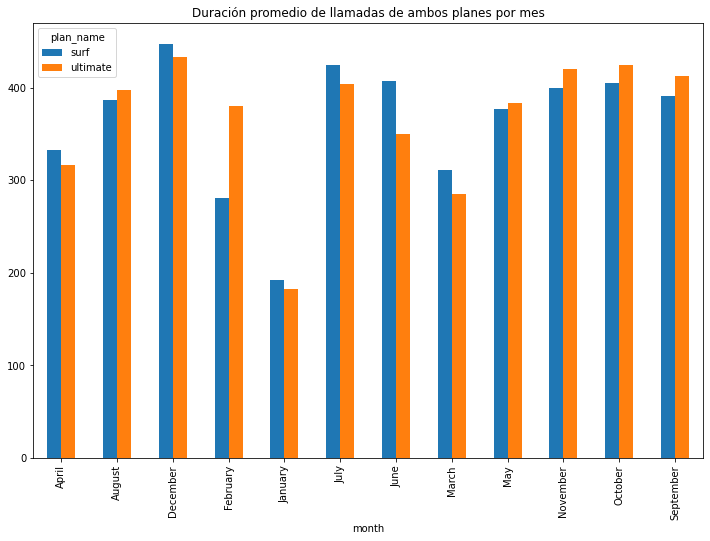

In [39]:
# Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
data_consolidada.pivot_table(index='month', columns='plan_name',
                             values='total_minutes', aggfunc='mean').plot.bar(figsize=(12,8),
                                                                              title='Duración promedio de llamadas de ambos planes por mes')


Podemos notar que los meses de Diciembre, Agosto, Julio, Noviembre, Octubre y Septiembre son los meses que más duración de llamadas tenemos con los 2 planes. En el mes de Febrero hubo una enorme diferencia de duración de llamadas entre el plan surf y el ultimate.

Text(0.5, 0.905, 'Número de minutos requeridos por los usuarios de cada plan por mes')

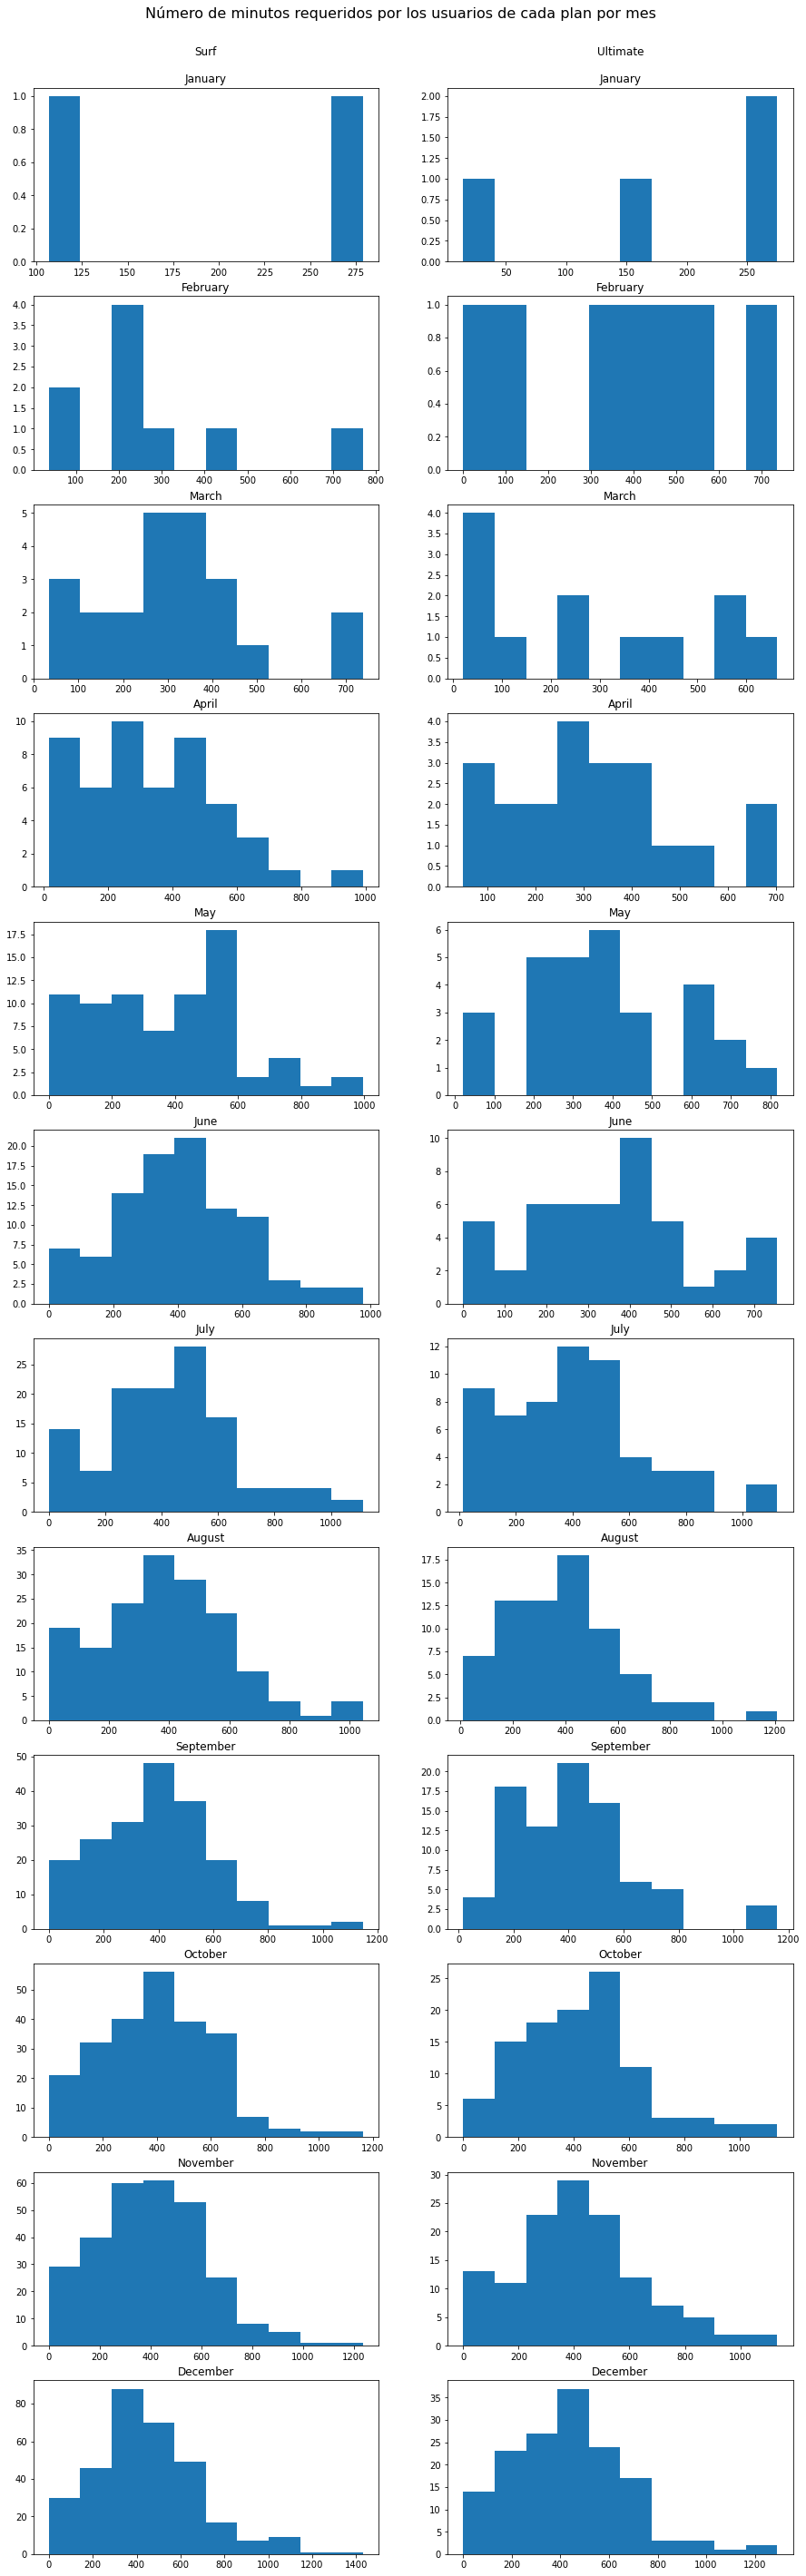

In [40]:
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.    
data_surf = data_consolidada.query('plan_name == "surf"').groupby(['user_id', 'month'])['total_minutes'].mean().reset_index()
data_ultimate = data_consolidada.query('plan_name == "ultimate"').groupby(['user_id', 'month'])['total_minutes'].mean().reset_index()

meses = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

fig, axs = plt.subplots(12, 2, figsize=(15, 50))
x = 0
y = 0

for mes in meses:
    axs[x,y].hist(x='total_minutes', data=data_surf[data_surf['month'] == mes])
    axs[x,y+1].hist(x='total_minutes', data=data_ultimate[data_ultimate['month'] == mes])
    if x == 0:
        axs[x, y].set_title('Surf\n\n' + mes)
        axs[x, y+1].set_title('Ultimate\n\n' + mes)
    else:
        axs[x, y].set_title(mes)
        axs[x, y+1].set_title(mes)
    x += 1
    
fig.suptitle('Número de minutos requeridos por los usuarios de cada plan por mes',
             y=0.905, fontsize=16)

Calculamos la media y la varianza de la duración de las llamadas. Esto, para tener más información de los datos y concluir si los usuarios de diferentes planes muestran comportamientos distintos

In [41]:
# Calcula la media y la varianza de la duración mensual de llamadas.
media_mes = data_consolidada.groupby(['plan_name']).agg(mean_minutes=('total_minutes',
                                                                    'mean'),
                                                       variance_minutes=('total_minutes',
                                                                         'var')).reset_index()
media_mes

,plan_name,mean_minutes,variance_minutes
0,surf,404.762390,49135.104891
1,ultimate,406.193083,51640.971402


In [42]:
# Verificamos que tanto varian los 2 planes
sample_1 = data_consolidada.query('plan_name == "surf"').total_minutes
sample_2 = data_consolidada.query('plan_name == "ultimate"').total_minutes

alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(sample_1, sample_2)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Los valores tienen una diferencia significativa")
else:
    print("Los valores no tienen una diferencia significativa")

p-value:  0.886848790639688
Los valores no tienen una diferencia significativa


<AxesSubplot:title={'center':'total_minutes'}, xlabel='plan_name'>

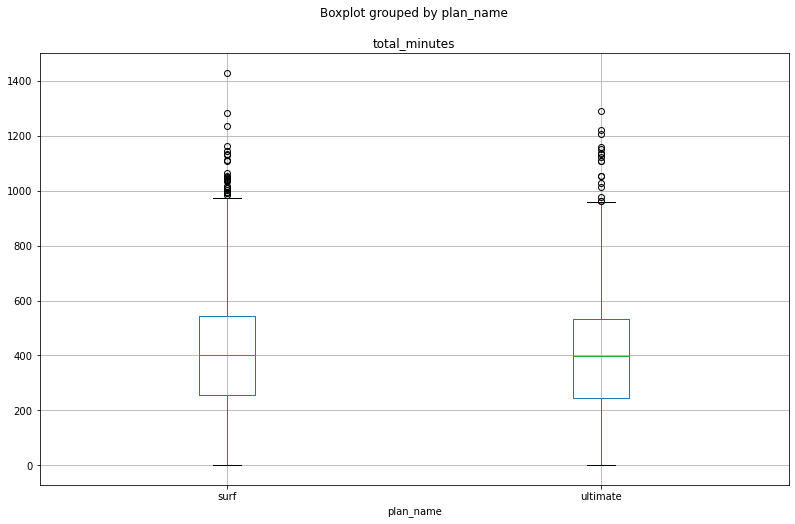

In [43]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
data_consolidada.boxplot(column='total_minutes', by='plan_name', figsize=(13,8))

En los primeros 2 grupos de graficos, pudimos ver un analisis detallado de como es la duración de las llamadas por ambos planes y los minutos por mes que requieren los usuarios de cada plan. Aunque notamos algunas diferencias que podrian indicar una diferencia de comportamiento entre los 2 planes, vemos que las diferencias dependen más del mes en cuestion que en los planes mismos. Esta hipotesis se refuerza al sacar la media y la varianza de nuestros 2 planes, tienen una diferencia minima y esto lo podemos ver graficamente en nuestra grafica de cajas; los limites de ambas cajas y su media parecen una copia identica.

Con todo esto expuesto, concluimos que no existe comportamiento diferente entre los planes en cuanto a llamadas se refiere.

### Mensajes

<AxesSubplot:title={'center':'Número promedio de mensajes de ambos planes por mes'}, xlabel='month'>

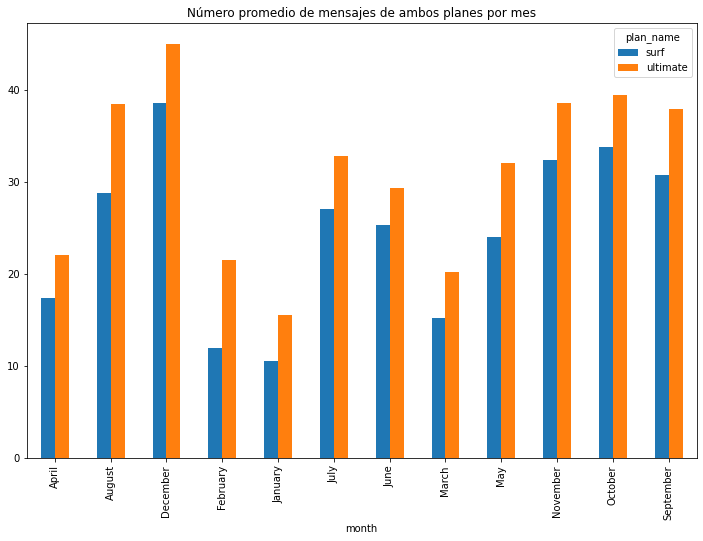

In [44]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
data_consolidada.pivot_table(index='month', columns='plan_name',
                             values='total_messages', aggfunc='mean').plot.bar(figsize=(12,8), title='Número promedio de mensajes de ambos planes por mes')

Podemos notar en este primer grafico, una clara tendencia de los usuarios del plan ultimate a mandar más mensajes que los usuarios del plan surf.

Text(0.5, 0.905, 'Número de mensajes requeridos por los usuarios de cada plan por mes')

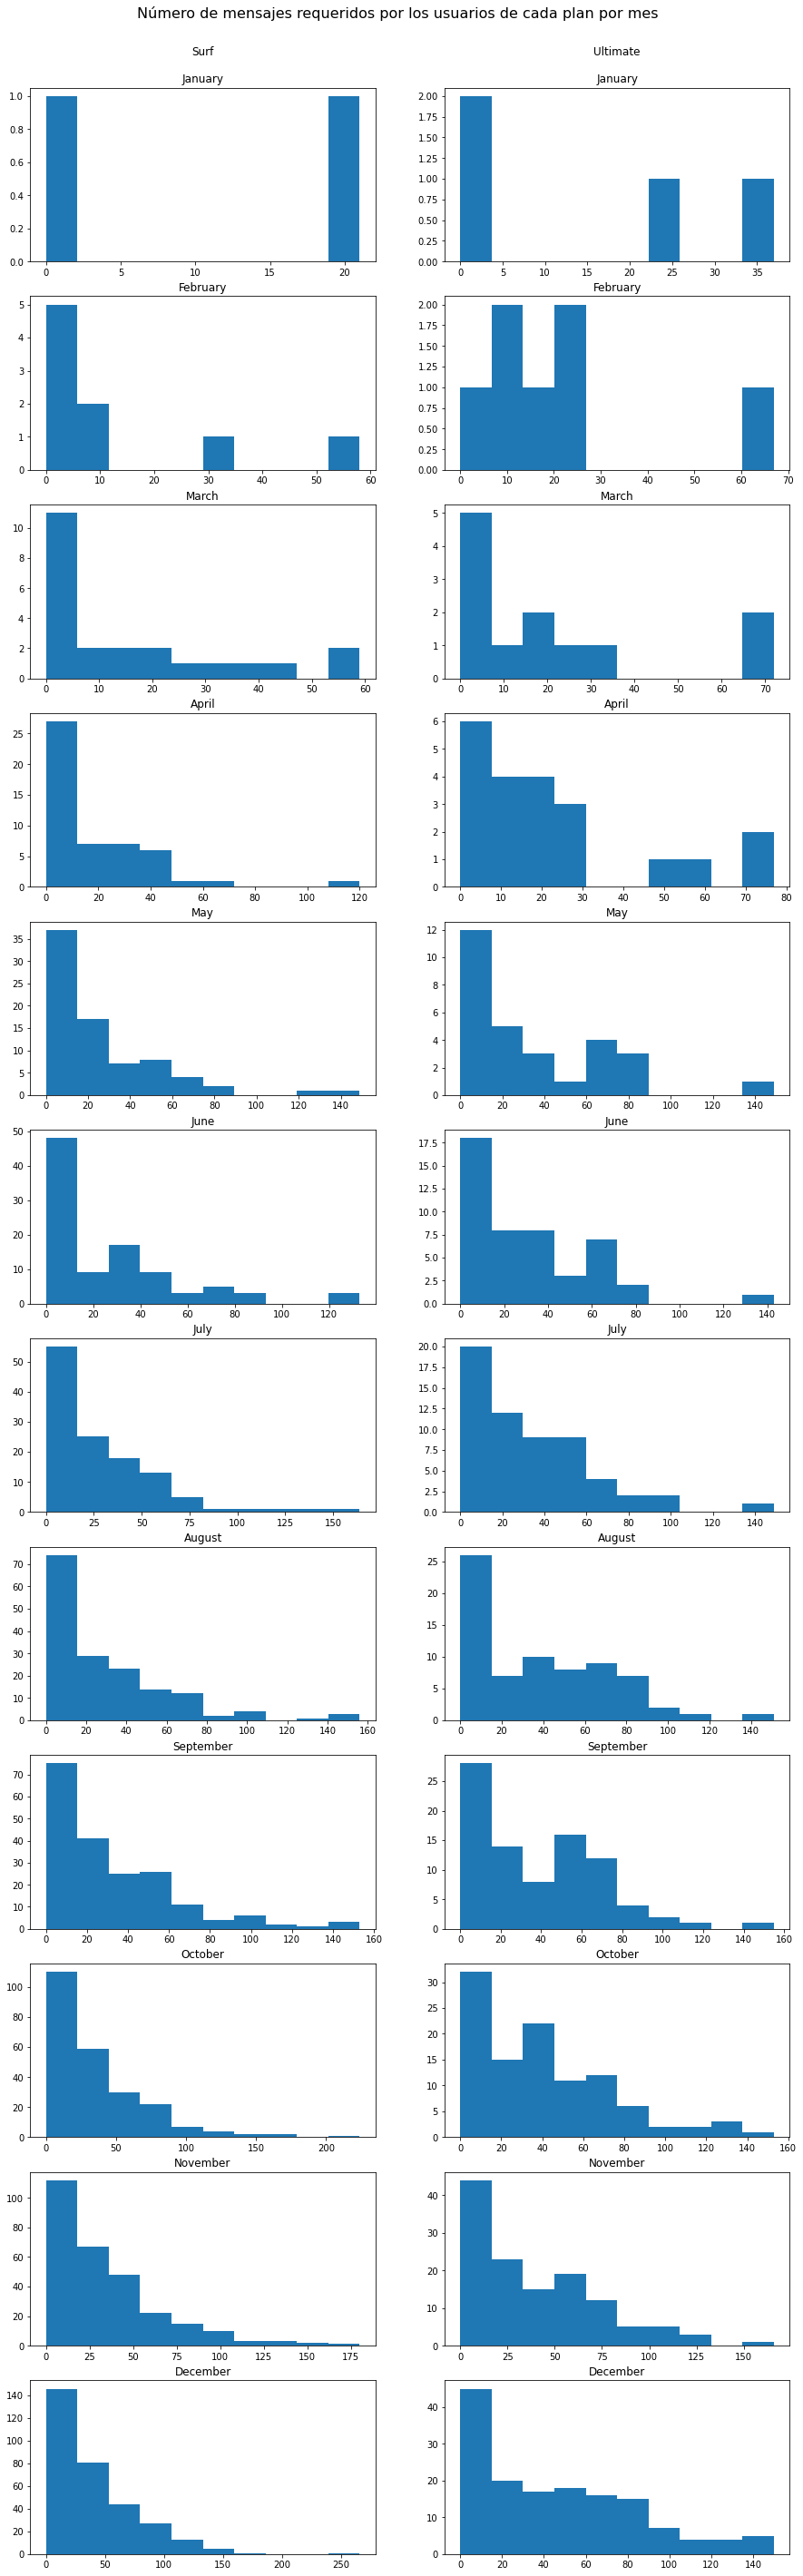

In [45]:
# Compara la cantidad de mensajes que necesitan los usuarios por plan
data_surf = data_consolidada.query('plan_name == "surf"').groupby(['user_id', 'month'])['total_messages'].mean().reset_index()
data_ultimate = data_consolidada.query('plan_name == "ultimate"').groupby(['user_id', 'month'])['total_messages'].mean().reset_index()

meses = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

fig, axs = plt.subplots(12, 2, figsize=(15, 50))
x = 0
y = 0

for mes in meses:
    axs[x,y].hist(x='total_messages', data=data_surf[data_surf['month'] == mes])
    axs[x,y+1].hist(x='total_messages', data=data_ultimate[data_ultimate['month'] == mes])
    if x == 0:
        axs[x, y].set_title('Surf\n\n' + mes)
        axs[x, y+1].set_title('Ultimate\n\n' + mes)
    else:
        axs[x, y].set_title(mes)
        axs[x, y+1].set_title(mes)
    x += 1
    
fig.suptitle('Número de mensajes requeridos por los usuarios de cada plan por mes',
             y=0.905, fontsize=16)

In [46]:
# Calcula la media y la varianza mensual de mensajes.
media_mes = data_consolidada.groupby(['plan_name']).agg(mean_messages=('total_messages',
                                                                    'mean'),
                                                       variance_messages=('total_messages',
                                                                         'var')).reset_index()
media_mes

,plan_name,mean_messages,variance_messages
0,surf,31.159568,1126.724522
1,ultimate,37.551389,1208.756744


In [47]:
# Verificamos que tanto varian los 2 planes
sample_1 = data_consolidada.query('plan_name == "surf"').total_messages
sample_2 = data_consolidada.query('plan_name == "ultimate"').total_messages

alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(sample_1, sample_2)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Los valores tienen una diferencia significativa")
else:
    print("Los valores no tienen una diferencia significativa")

p-value:  2.9663595422753044e-05
Los valores tienen una diferencia significativa


<AxesSubplot:title={'center':'total_messages'}, xlabel='plan_name'>

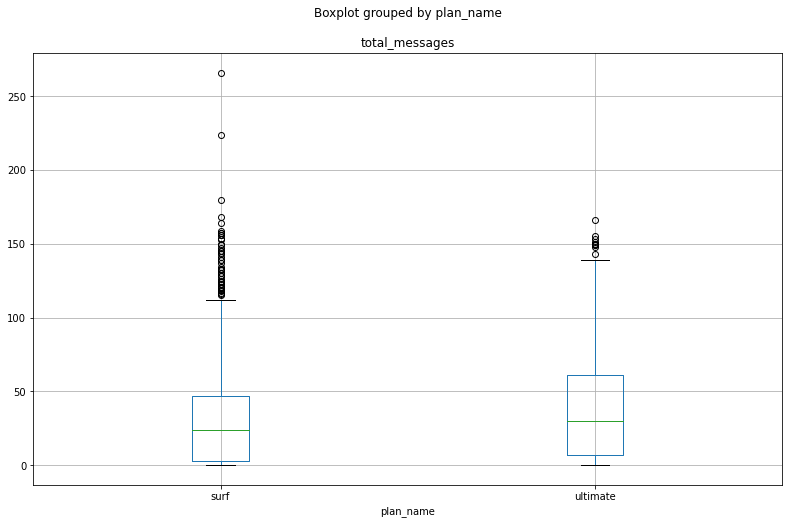

In [48]:
# Traza un diagrama de caja para visualizar la distribución mensual de mensajes.
data_consolidada.boxplot(column='total_messages', by='plan_name', figsize=(13,8))

Como veiamos en el primer grafico, se detecto que cada mes los usuarios Ultimate enviaban más mensajes que los usarios Surf, esta hipotesis se reforzo al sacar la varianza y la media de los mensajes. En promedio, los usuarios envian 7 mensajes más que los usuarios surf y al comparar ambos planes con su varianza, detectamos con un 95% de confianza que hay una diferencia significativa entre ambos planes. 

Finalmente, con ayuda de nuestro ultimo grafico, podemos ver claramentente como la caja de los usarios ultimate es mayor a los surf tanto para la media como para los limetes inferiores y superiores.

Habiendo expuesto todos estos datos, concluimos que los usuarios ultimate tienden a enviar más mensajes que los usarios Surf.

### Internet

<AxesSubplot:title={'center':'Número promedio de MB gastados por ambos planes por mes'}, xlabel='month'>

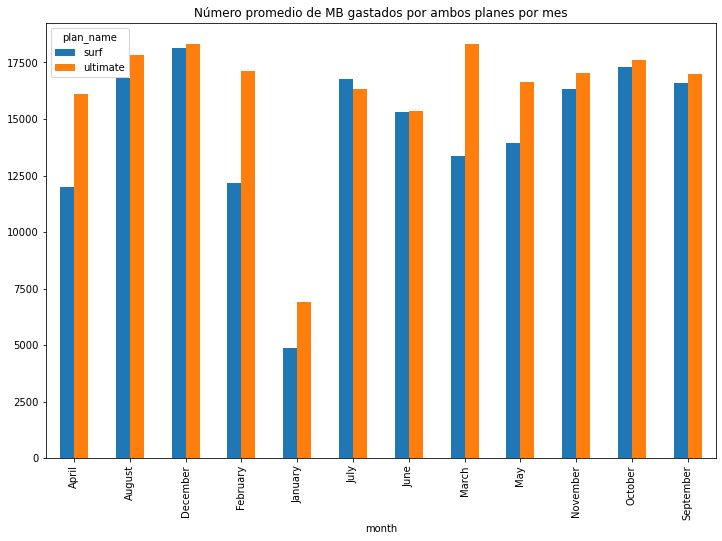

In [49]:
# Comprara el número de MB que tienden a gastar cada mes los usuarios de cada plan
data_consolidada.pivot_table(index='month', columns='plan_name',
                             values='total_mb_used', aggfunc='mean').plot.bar(figsize=(12,8), title='Número promedio de MB gastados por ambos planes por mes')

Podemos notar en este primer grafico que los usuarios Ultimate tienden a gastar MB que los usuarios Surf. Algunos meses estan casi a la par pero hay algunos que grandes diferencias

Text(0.5, 0.905, 'Número de MB requeridos por los usuarios de cada plan por mes')

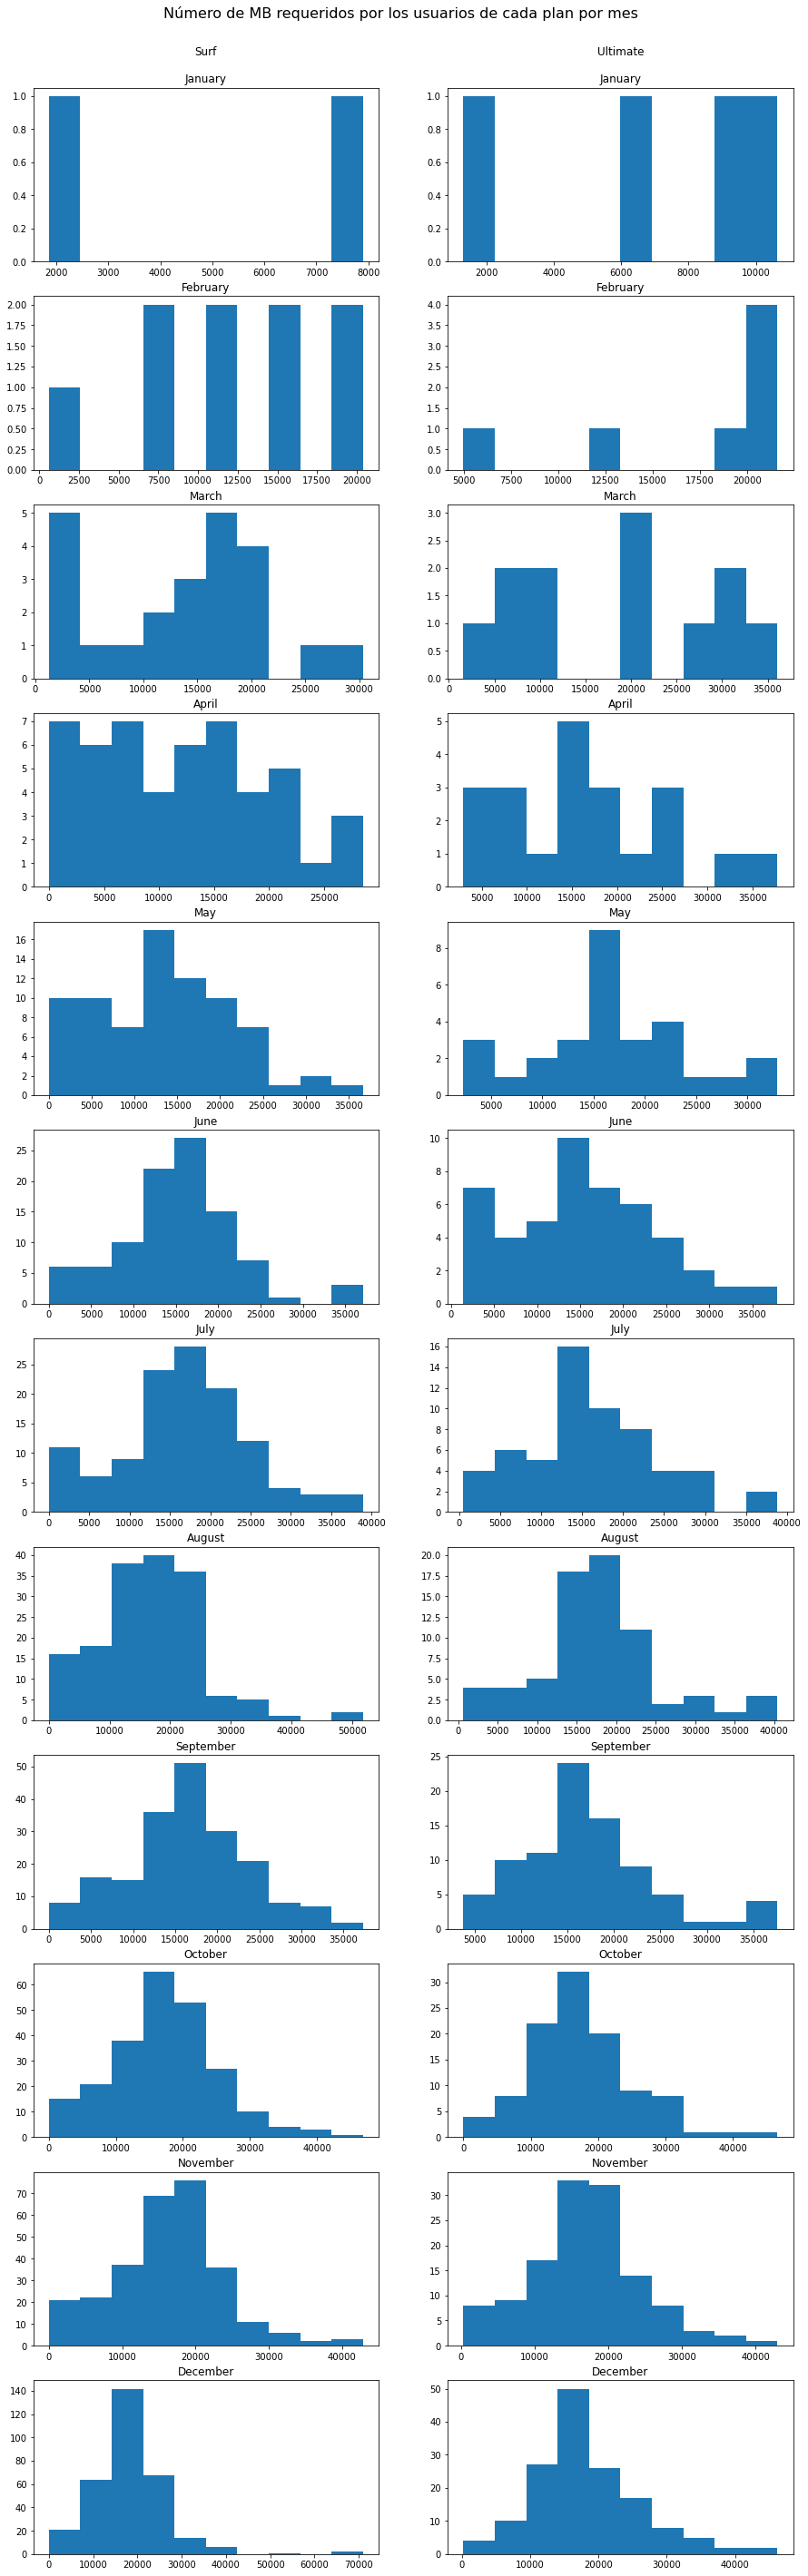

In [50]:
# Compara la cantidad de MB que necesitan los usuarios por plan
data_surf = data_consolidada.query('plan_name == "surf"').groupby(['user_id', 'month'])['total_mb_used'].mean().reset_index()
data_ultimate = data_consolidada.query('plan_name == "ultimate"').groupby(['user_id', 'month'])['total_mb_used'].mean().reset_index()

meses = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

fig, axs = plt.subplots(12, 2, figsize=(15, 50))
x = 0
y = 0

for mes in meses:
    axs[x,y].hist(x='total_mb_used', data=data_surf[data_surf['month'] == mes])
    axs[x,y+1].hist(x='total_mb_used', data=data_ultimate[data_ultimate['month'] == mes])
    if x == 0:
        axs[x, y].set_title('Surf\n\n' + mes)
        axs[x, y+1].set_title('Ultimate\n\n' + mes)
    else:
        axs[x, y].set_title(mes)
        axs[x, y+1].set_title(mes)
    x += 1
    
fig.suptitle('Número de MB requeridos por los usuarios de cada plan por mes',
             y=0.905, fontsize=16)

In [51]:
# Calcula la media y la varianza mensual de MB gastados.
media_mes = data_consolidada.groupby(['plan_name']).agg(mean_mb_used=('total_mb_used',
                                                                    'mean'),
                                                       variance_mb_used=('total_mb_used',
                                                                         'var')).reset_index()
media_mes

,plan_name,mean_mb_used,variance_mb_used
0,surf,16558.283490,6.421640e+07
1,ultimate,17214.699694,6.165229e+07


In [52]:
# Verificamos que tanto varian los 2 planes
sample_1 = data_consolidada.query('plan_name == "surf"').total_mb_used
sample_2 = data_consolidada.query('plan_name == "ultimate"').total_mb_used

alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(sample_1, sample_2)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Los valores tienen una diferencia significativa")
else:
    print("Los valores no tienen una diferencia significativa")

p-value:  0.0670825864283899
Los valores no tienen una diferencia significativa


<AxesSubplot:title={'center':'total_mb_used'}, xlabel='plan_name'>

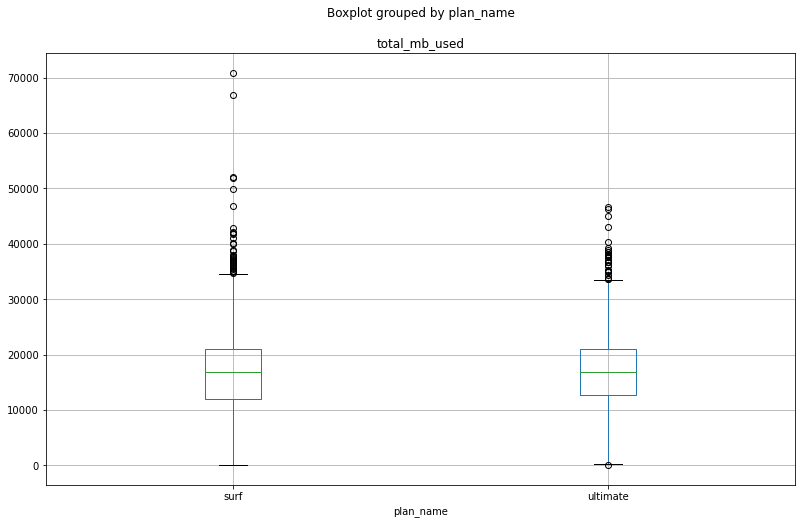

In [53]:
# Traza un diagrama de caja para visualizar la distribución mensual de gasto de MB.
data_consolidada.boxplot(column='total_mb_used', by='plan_name', figsize=(13,8))

Como habiamos comentado en el primer gráfico, parecia indicar que habia una diferencia de comportamiento entre los usuarios del plan Ultimate con el plan Surf, donde los primeros consumian más MB de internet.

Sin embargo, al ver las distribuciones pudimos ver que eran más bien parecidas en general; esto se reforzo al generar las medias y las varianzas de los planes, al comparar las varianzas vemos que con 95% de confianza no hay una diferencia significativa y al ver nuestro grafico de cajas podemos notar claramente como ambas cajas parecen copias exactas.

Con todo esto expuesto, concluimos que el comportamiento entre los planes con respecto al consumo de internet no presenta diferencias significativas.

## Ingreso

Una vez visto como era el comportamiento de los usarios respecto a las llamadas, mensajes y uso de internet; vamos a pasar a nuestro ultimo punto de este análisis.

Vamos a analizar estadisticamente como es el ingreso entre los planes, con el objetivo de identificar el que mejor rendimientos nos entrega

<AxesSubplot:title={'center':'Ingreso promedio de ambos planes por mes'}, xlabel='month'>

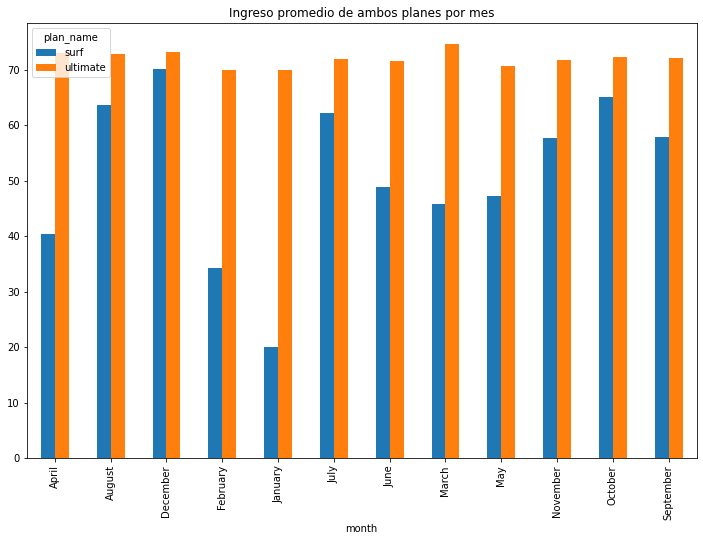

In [54]:
# Comprara como tienden los ingresos cada mes de cada plan
data_consolidada.pivot_table(index='month', columns='plan_name',
                             values='total_month_cost', aggfunc='mean').plot.bar(figsize=(12,8), title='Ingreso promedio de ambos planes por mes')

Viendo nuestro primer gráfico podemos ver como el plan premium en todos los meses nos entrega en promedio mayores ingresos que el plan Surf.

Text(0.5, 0.905, 'Ingresos promedio de cada plan por mes')

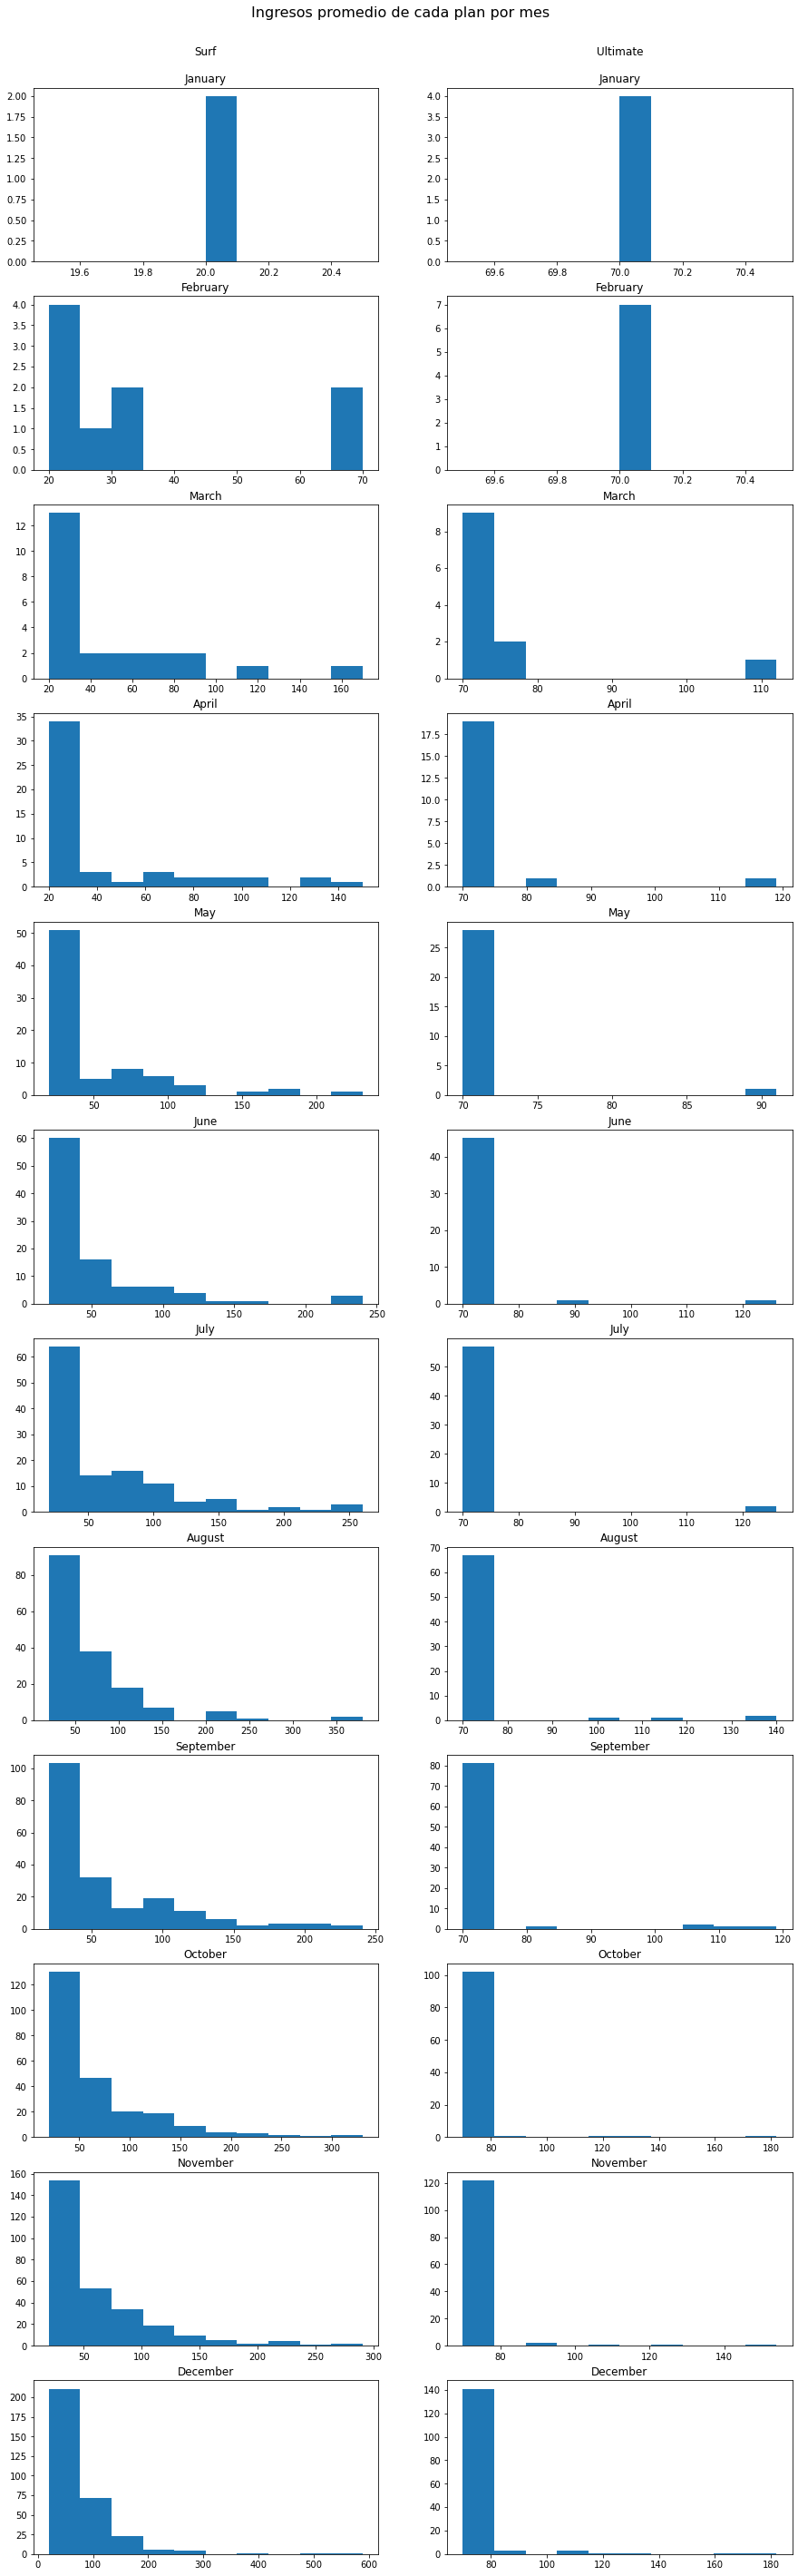

In [55]:
# Comparamos la distribución de los ingresos por mes de los planes
data_surf = data_consolidada.query('plan_name == "surf"').groupby(['user_id', 'month'])['total_month_cost'].mean().reset_index()
data_ultimate = data_consolidada.query('plan_name == "ultimate"').groupby(['user_id', 'month'])['total_month_cost'].mean().reset_index()

meses = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

fig, axs = plt.subplots(12, 2, figsize=(15, 50))
x = 0
y = 0

for mes in meses:
    axs[x,y].hist(x='total_month_cost', data=data_surf[data_surf['month'] == mes])
    axs[x,y+1].hist(x='total_month_cost', data=data_ultimate[data_ultimate['month'] == mes])
    if x == 0:
        axs[x, y].set_title('Surf\n\n' + mes)
        axs[x, y+1].set_title('Ultimate\n\n' + mes)
    else:
        axs[x, y].set_title(mes)
        axs[x, y+1].set_title(mes)
    x += 1
    
fig.suptitle('Ingresos promedio de cada plan por mes',
             y=0.905, fontsize=16)

Al comparar las distribuciones, vemos que en promedio los usuarios del plan Surf tienden a pagar más extras en su plan que los usuarios Ultimate, sin embargo estos extras no llegan a superar los 50 dolares en costo total por mes para la mayoria de usuarios Surf que comparados con los 70 dolares que cuesta el plan Ultimate, tenemos 20 dolares en promedio de diferencia aun con extras

<AxesSubplot:title={'center':'total_month_cost'}, xlabel='plan_name'>

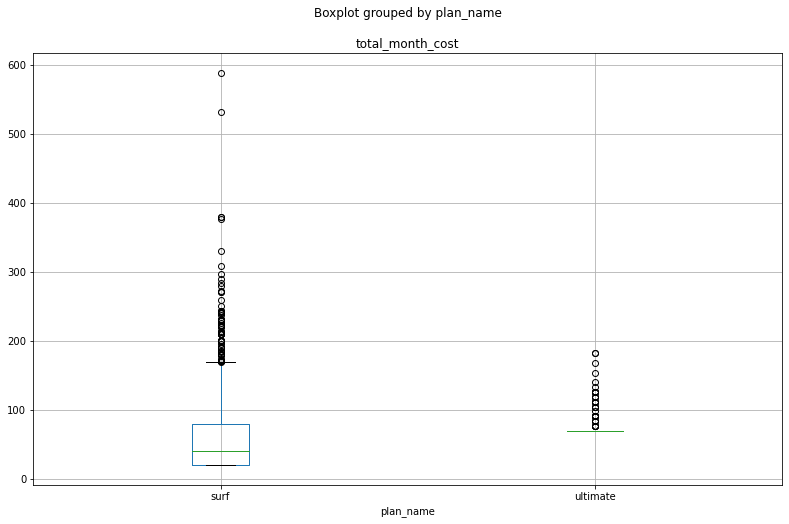

In [56]:
# Traza un diagrama de caja para visualizar la distribución mensual de gasto de MB.
data_consolidada.boxplot(column='total_month_cost', by='plan_name', figsize=(13,8))

Como habiamos comentado en nuestros dos primeros gráficos, parecia indicar que habia una diferencia entre los ingresos del plan Surf con el plan Ultimate, siendo este ultimo el que mayor ingreso nos entrega cada mes.

Al ver las distribucioes pudimos ver que los usuarios Surf tienden a generar costos extra mientras que en el plan Ultimate la mayoria de los usuarios pagan solo su plan mensual sin costos extra. Tambien notamos que el costo incluso con costos extra no llegan en promedio a los 70 dolares que cuesta el Ultimate y con ayuda de nuestro ultimo gráfico podemos ver graficamente como la media de los usuarios surf esta por los 50 dolares con limite superior de la caja en casi los 70 dolares pero son los casos menos, por otro lado nuestra grafica del plan ultimate esta aplanada en los 70 dolares convergiendo la media con los limites y confirmando lo que habiamos visto en las distribuciones.

Todo parece indicar que nuestro plan Ultimate es el que mejor ingresos nos entrega en comparación al plan Surf.

## Probar las hipótesis estadísticas.

Para terminar de confirmar nuestras observaciones, realizaremos una prueba estadistica.
Vamos a enunciar que el ingreso promedio de los usuarios de los planes Ultimate y Surf son iguales.

Para esta prueba, nuestra hipotesis nula es que "el ingreso promedio de los usuarios de los planes Ultimate y Surf son iguales".

Nuestra hipotesis alternativa es que "el ingreso promedio de los usuarios de los planes Ultimate y Surf son diferentes"

Como prueba estadistica realizaremos la prueba de igualdad de las medias de dos poblaciones y nuestro indice de confianza sera del 95%

In [57]:
# Prueba las hipótesis
sample_1 = data_consolidada.query('plan_name == "surf"').total_month_cost
sample_2 = data_consolidada.query('plan_name == "ultimate"').total_month_cost

alpha = 0.05 # el nivel de significancia estadística crítica
# si el valor p es menor que alfa, rechazamos la hipótesis

results = st.ttest_ind(sample_1, sample_2)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  9.342071816297584e-09
Rechazamos la hipótesis nula


Una vez realizado la prueba, podemos ver que nuestro valor p es bastante bajo a nuestro nivel de confianza (95% = 0.05), esto nos indica que la hipotesis nula es rechazada y que ambos planes en terminos de ingresos tienen diferencias significativas.

Con esta información y las observaciones anteriormente expuestas, podemos concluir que el plan que mayores ingresos nos entrega es el plan Ultimate y se le deberia dar mayor publicidad para poder generar mayores ingresos

Como punto final, nos interesa saber si el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones. Para poder dar respuesta a esta solicitud, se realizara una prueba estadistica.

Para esta prueba, nuestra hipotesis nula es que "el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones".

Nuestra hipotesis alternativa es que "el ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones"

Como prueba estadistica realizaremos la prueba de igualdad de las medias de dos poblaciones y nuestro indice de confianza sera del 95%

In [58]:
# Vemos nuestro dataset consolidado
data_consolidada

,user_id,month,total_calls,calls_lost,calls_success,total_minutes,total_messages,total_mb_used,plan_name,messages_included,...,usd_per_message,usd_per_minute,extra_minutes,extra_messages,extra_mb,extra_cost_minutes,extra_cost_messages,extra_cost_mb,extra_cost_total,total_month_cost
0,1000,December,16.0,0.0,16.0,116.83,11.0,1901.47,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.00,0,0.00,70.00
1,1006,December,9.0,2.0,7.0,54.79,139.0,32118.82,ultimate,1000,...,0.01,0.01,0.0,0.0,1398.82,0.0,0.00,14,14.00,84.00
2,1006,November,2.0,0.0,2.0,9.32,15.0,2068.37,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.00,0,0.00,70.00
3,1008,December,85.0,22.0,63.0,600.29,26.0,14689.33,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.00,0,0.00,70.00
4,1008,November,63.0,15.0,48.0,422.81,37.0,23676.72,ultimate,1000,...,0.01,0.01,0.0,0.0,0.00,0.0,0.00,0,0.00,70.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1194,October,0.0,0.0,0.0,0.00,88.0,31538.39,surf,50,...,0.03,0.03,0.0,38.0,16178.39,0.0,1.14,160,161.14,181.14
2289,1194,September,0.0,0.0,0.0,0.00,76.0,37298.02,surf,50,...,0.03,0.03,0.0,26.0,21938.02,0.0,0.78,220,220.78,240.78
2290,1349,December,0.0,0.0,0.0,0.00,61.0,13039.91,surf,50,...,0.03,0.03,0.0,11.0,0.00,0.0,0.33,0,0.33,20.33
2291,1349,November,0.0,0.0,0.0,0.00,72.0,17128.26,surf,50,...,0.03,0.03,0.0,22.0,1768.26,0.0,0.66,20,20.66,40.66


Para realizar la prueba estadística, es necesario agregar a nuestro dataset consolidado la información geografica de nuestros usuarios

In [59]:
data_consolidada_final = data_consolidada.groupby('user_id')['total_month_cost'].sum().reset_index()
data_consolidada_final = data_consolidada_final.merge(users, on='user_id')
data_consolidada_final.head()

,user_id,total_month_cost,first_name,last_name,age,city,reg_date,plan,churn_date,user_active,days_suscribed,grouped_age
0,1000,70.00,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,True,-1.0,41-50
1,1001,250.09,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,True,-1.0,21-30
2,1002,100.00,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,True,-1.0,31-40
3,1003,156.23,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,True,-1.0,51-60
4,1004,610.00,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,True,-1.0,31-40


In [60]:
# Vemos los datos unicos de city
data_consolidada_final.city.unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [61]:
# Prueba las hipótesis
sample_1 = data_consolidada_final[data_consolidada_final['city'].str.contains('NY-NJ')].total_month_cost
sample_2 = data_consolidada_final[data_consolidada_final['city'].str.contains('NY-NJ') == False].total_month_cost

alpha = 0.05 # el nivel de significancia estadística crítica

# si el valor p es mayor que alfa, rechazamos la hipótesis
results = st.ttest_ind(sample_1, sample_2)

print('p-value: ', results.pvalue)

if results.pvalue > alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  0.5798995337018191
Rechazamos la hipótesis nula


Una vez realizada la prueba, el valor p nos dice que aunque los ingresos promedio entre la region de NY-NJ y las demas regiones son diferentes, existe un 56% de probabilidad de obtener una diferencia de ese tamaño o mayor. Esta probabilidad es claramente demasiado alta para concluir que existe una diferencia significativa entre los ingresos promedios.

Por lo que se rechaza la hipotesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones

## Conclusión general

Como conclusiones generales del análisis, podemos enumerar las siguientes:

1. El comportamiento entre los usuarios de los diferentes planes es similar en temas de llamadas y uso de internet; sin embargo para el tema de mensajes, pudimos notar que los usuarios del plan Ultimate tienden a mandar más mensajes que los usuarios del plan Surf.


2. Los usuarios del plan Surf tienden a generar más cargos extra que los usuarios del plan Ultimate, aún con este tendencia de cargos extra, los ingresos promedio de los usuarios Surf quedan 20 dolares por debajo de los ingresos del plan Ultimate. Esta situación habre la posibilidad de aumentar el costo base del plan o de los cargos extra para intentar acortar esta diferencia entre ambos planes.


3. El plan Ultimate es el plan que más ingresos genera y deberia promocionarse para poder aumentar estos ingresos.


4. Los ingresos promedio de los usuarios del área de NY-NJ son significativamente similares a los de otras regiones, por lo que no se recomienda concentrar los esfuerzos en esta region y más si los costes de publicidad en esta región son mayores que en otras regiones